In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing_extensions import TypedDict
from typing import Annotated

from langchain_community.tools import tool
from langchain.chat_models import init_chat_model

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [3]:
memory = MemorySaver()

In [4]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [5]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        'MARUTI': 14090.00,
        'HEROMOTOCO': 4990.00,
        'NESTLEIND': 1146.40,
        'BAJFINANCE': 905.05,
        'BAJAJ-AUTO': 8592.00
    }.get(symbol,0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

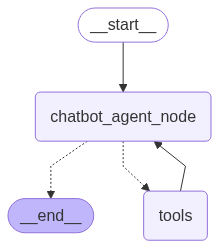

In [8]:
def chatbot_agent(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node("chatbot_agent_node",chatbot_agent)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot_agent_node")
builder.add_conditional_edges("chatbot_agent_node", tools_condition)
builder.add_edge("tools","chatbot_agent_node")

graph = builder.compile(checkpointer = memory)

from IPython.display import display,Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
config = {"configurable":{"thread_id":"1"}}

msg = "I want to buy 20 MARUTI stocks using current price. Then 15 HEROMOTOCO. What will be the total cost?"

state = graph.invoke({"messages":[{"role":"user","content":msg}]}, config = config )
print(state["messages"][-1].content)

Okay, I have the stock prices.

*   MARUTI: 14090
*   HEROMOTOCO: 4990

The total cost will be (20 \* 14090) + (15 \* 4990) = 281800 + 74850 = 356650

Therefore, the total cost for 20 MARUTI stocks and 15 HEROMOTOCO stocks would be 356650.


In [11]:
msg1 = "tell me the current price of 5 NESTLEIND stocks"

config1 = {"configurable":{"thread_id":2}}

state = graph.invoke({"messages":{"role":"user","content":msg1}}, config = config1)
print(state["messages"][-1].content)

The current price of one NESTLEIND stock is 1146.4. Therefore, the current price of 5 NESTLEIND stocks is 5 * 1146.4 = 5732.


In [12]:
msg = "Using the current price tell me the total price of 10 BAJFINANCE stocks and add it to previous total cost"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

The current price of one BAJFINANCE stock is 905.05. Therefore, the current price of 10 BAJFINANCE stocks is 10 * 905.05 = 9050.5.
The previous total cost was 5732. Adding the current price of 10 BAJFINANCE stocks, the new total cost is 5732 + 9050.5 = 14782.5.


In [13]:
msg = "Using the current price tell me the total price of 10 BAJFINANCE stocks and add it to previous total cost"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config)
print(state["messages"][-1].content)

The current price of BAJFINANCE is 905.05.

The cost of 10 BAJFINANCE stocks is 10 * 905.05 = 9050.5

Adding this to the previous total cost of 356650, the new total cost is 356650 + 9050.5 = 365700.5


In [14]:
msg = "Tell me the current price of 5 BAJAJ-AUTO stocks and add it to previous total"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

The current price of one BAJAJ-AUTO stock is 8592. Therefore, the current price of 5 BAJAJ-AUTO stocks is 5 * 8592 = 42960.
The previous total was 14782.5. Adding the current price of 5 BAJAJ-AUTO stocks, the new total is 14782.5 + 42960 = 57742.5.


In [15]:
msg = "remove the previous 10 BAJFINANCE price and tell me"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
print(state["messages"][-1].content)

Okay, the previous total was 57742.5, which included the price of 5 NESTLEIND stocks and 5 BAJAJ-AUTO stocks and 10 BAJFINANCE stocks. The price of 10 BAJFINANCE stocks was 9050.5. Removing this from the current total, the new total is 57742.5 - 9050.5 = 48692.


In [16]:
print("you nailed man")

you nailed man
